# Лабораторная работа 4. Глубокое обучение


In [ ]:

from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, 
                                     LeakyReLU, BatchNormalization, Dropout, Input, Lambda)
from tqdm import tqdm


### Шаг 1. Подготовка данных

Для начала подгрузим данные из MNIST и посмотрим на них

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

print(f"Форма тренировочных данных: {x_train.shape}")
print(f"Форма тестовых данных: {x_test.shape}")

Форма тренировочных данных: (60000, 28, 28, 1)
Форма тестовых данных: (10000, 28, 28, 1)


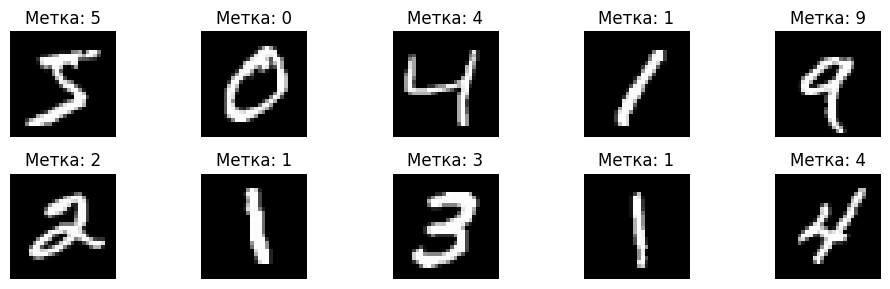

In [ ]:
plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Метка: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Для информации посмотрим, как распределены классы

In [ ]:
def print_class_distribution(y, name):
    unique, counts = np.unique(y, return_counts=True)
    print(f"{name}:")
    for digit, count in zip(unique, counts):
        print(f"Цифра {digit}: {count:5} примеров ({count/len(y)*100:.1f}%)")
    
print_class_distribution(y_train, "Тренировочный набор")
print_class_distribution(y_test, "Тестовый набор")

Тренировочный набор:
Цифра 0:  5923 примеров (9.9%)
Цифра 1:  6742 примеров (11.2%)
Цифра 2:  5958 примеров (9.9%)
Цифра 3:  6131 примеров (10.2%)
Цифра 4:  5842 примеров (9.7%)
Цифра 5:  5421 примеров (9.0%)
Цифра 6:  5918 примеров (9.9%)
Цифра 7:  6265 примеров (10.4%)
Цифра 8:  5851 примеров (9.8%)
Цифра 9:  5949 примеров (9.9%)
Тестовый набор:
Цифра 0:   980 примеров (9.8%)
Цифра 1:  1135 примеров (11.3%)
Цифра 2:  1032 примеров (10.3%)
Цифра 3:  1010 примеров (10.1%)
Цифра 4:   982 примеров (9.8%)
Цифра 5:   892 примеров (8.9%)
Цифра 6:   958 примеров (9.6%)
Цифра 7:  1028 примеров (10.3%)
Цифра 8:   974 примеров (9.7%)
Цифра 9:  1009 примеров (10.1%)


В целом распределение хорошее, примерно равномерное

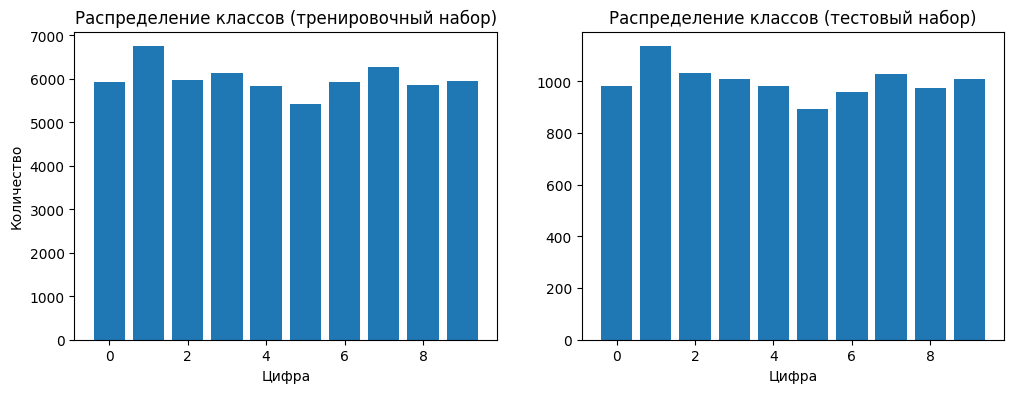

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(np.unique(y_train), np.bincount(y_train))
plt.title("Распределение классов (тренировочный набор)")
plt.xlabel("Цифра")
plt.ylabel("Количество")

plt.subplot(1, 2, 2)
plt.bar(np.unique(y_test), np.bincount(y_test))
plt.title("Распределение классов (тестовый набор)")
plt.xlabel("Цифра")
plt.show()

Сделаем аугментацию наших данных

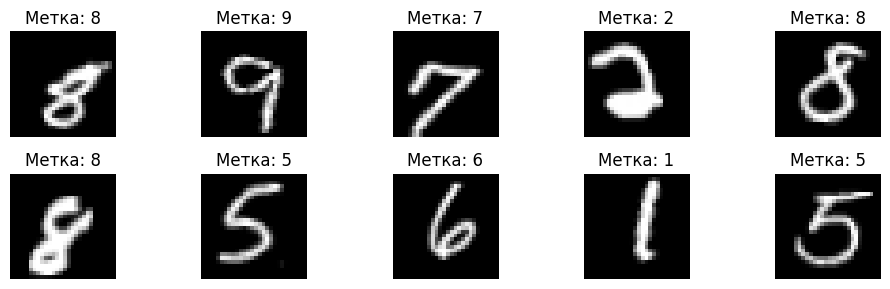

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

augmented_images, augmented_labels = next(datagen.flow(x_train, y_train, batch_size=10))

plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(augmented_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Метка: {augmented_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Преобразуем данные для PCA

In [ ]:
x_train_flat = x_train.reshape(len(x_train), -1)
x_test_flat = x_test.reshape(len(x_test), -1)

print(f"Размер тренировочных данных после преобразования: {x_train_flat.shape}")
print(f"Размер тестовых данных после преобразования: {x_test_flat.shape}")

Размер тренировочных данных после преобразования: (60000, 784)
Размер тестовых данных после преобразования: (10000, 784)


In [ ]:
print("По всем тренировочным данным:")
print(f"Минимальное значение: {x_train.min():.4f}")
print(f"Максимальное значение: {x_train.max():.4f}")
print(f"Среднее значение: {x_train.mean():.4f}")
print(f"Стандартное отклонение: {x_train.std():.4f}")

По всем тренировочным данным:
Минимальное значение: 0.0000
Максимальное значение: 1.0000
Среднее значение: 0.1307
Стандартное отклонение: 0.3081


Попробуем добавить шум и сравним с изначальными изображениями

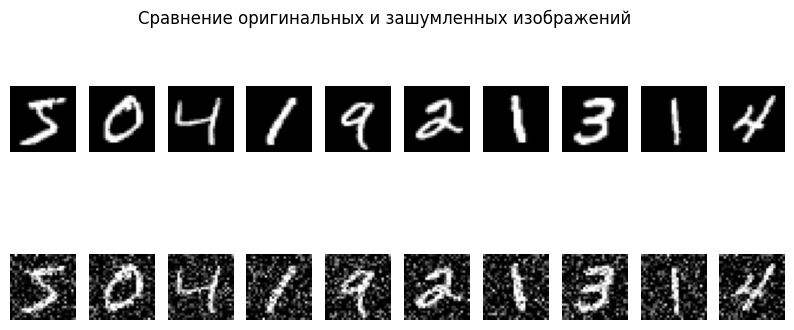

In [ ]:
noise_factor = 0.3

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    
    plt.subplot(2, 10, i + 11)
    plt.imshow(x_train_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle("Сравнение оригинальных и зашумленных изображений")
plt.show()

Сделаем сабсет для тестов

In [ ]:
subset_size = 1000
small_x_train = x_train[:subset_size]
small_y_train = y_train[:subset_size]

small_x_train.shape

Создан поднабор с 1000 примерами
Размер поднабора: (1000, 28, 28, 1)


Влияние распределения классов:
• Сбалансированные данные обеспечивают равномерное обучение модели
• Дисбаланс может привести к смещению модели в сторону более частых классов

Полезные преобразования для генерации:
• Умеренные геометрические преобразования (поворот, сдвиг, масштабирование)
• Добавление контролируемого шума
• Изменение контраста

Польза добавления шума:
• Повышает устойчивость модели к артефактам в реальных данных
• Служит формой регуляризации, предотвращая переобучение
• Особенно полезно для автоэнкодеров и моделей шумоподавления

### Шаг 2. Реализация автокодировщика (AE)

In [ ]:
LATENT_DIM = 64
INPUT_SHAPE = (28, 28, 1)

input_layer = Input(shape=INPUT_SHAPE)
flatten = Flatten()(input_layer)
encoded = Dense(LATENT_DIM, activation='relu')(flatten)

decoded = Dense(28 * 28, activation='sigmoid')(encoded)
reshaped = Reshape(INPUT_SHAPE)(decoded)

autoencoder = Model(input_layer, reshaped)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_85 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_55 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 784)            │        50,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_43 (Reshape)            │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,200 (395.31 KB)

 Trainable params: 101,200 (395.31 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.3502 - val_loss: 0.1626
Epoch 2/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1531 - val_loss: 0.1264
Epoch 3/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1225 - val_loss: 0.1087
Epoch 4/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1067 - val_loss: 0.0974
Epoch 5/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0966 - val_loss: 0.0900
Epoch 6/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0895 - val_loss: 0.0850
Epoch 7/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0850 - val_loss: 0.0815
Epoch 8/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0816 - val_loss: 0.0791
Epoch 9/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0794 - val_loss: 0.0775
Epoch 10/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0778 - val_loss: 0.0763
Epoch 11/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0768 - val_loss: 0.0755
Epoch 12/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/ste

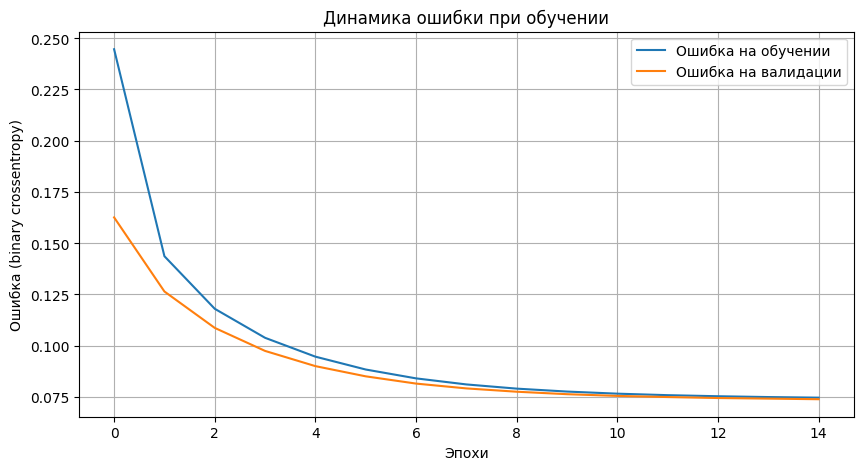

In [ ]:
history = autoencoder.fit(
    x_train, x_train,
    epochs=15,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test)
)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Ошибка на обучении')
plt.plot(history.history['val_loss'], label='Ошибка на валидации')
plt.title('Динамика ошибки при обучении')
plt.xlabel('Эпохи')
plt.ylabel('Ошибка (binary crossentropy)')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


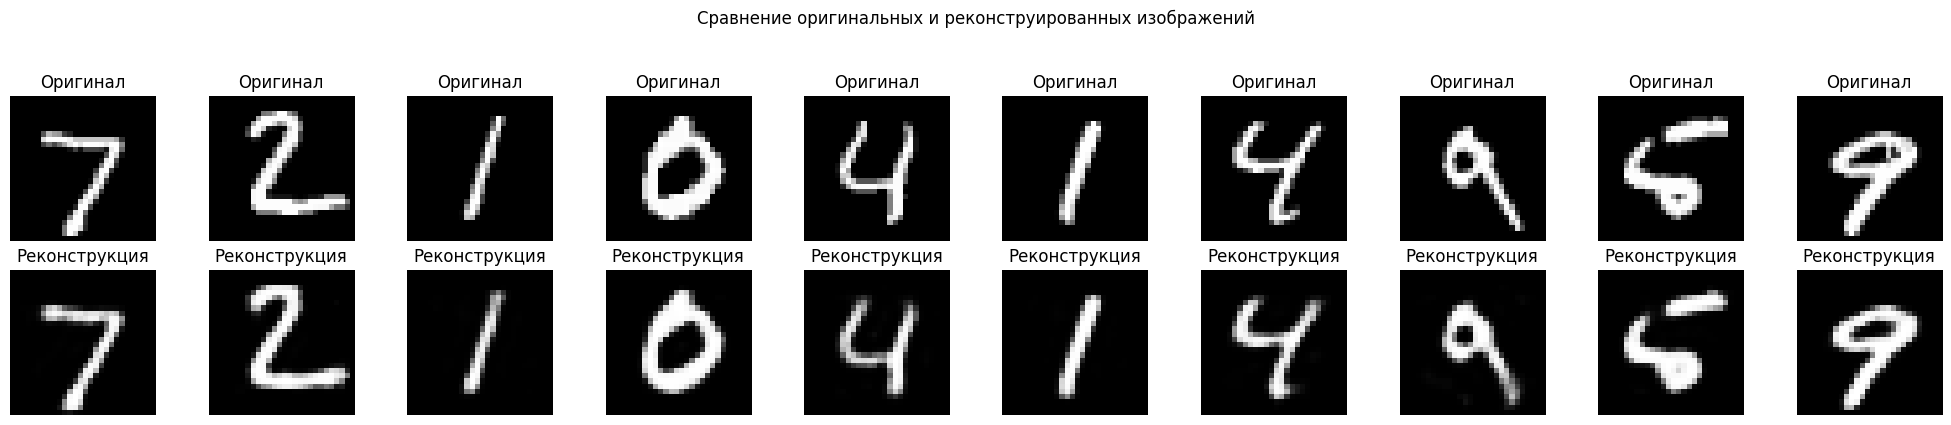

In [ ]:
n = 10
test_images = x_test[:n]

reconstructed = autoencoder.predict(test_images)

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Оригинал")
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
    plt.title("Реконструкция")
    plt.axis('off')
plt.suptitle('Сравнение оригинальных и реконструированных изображений', y=1.05)
plt.tight_layout()
plt.show()

Проведем анализ латентного пространства

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Пример латентного представления (размерность 64):
[ 6.876545    5.459714    2.965222    4.8937583   6.5785027   0.7703079
  6.8477035   6.290347    4.967551    1.9547908   3.014716    2.7317028
  6.9296856   4.6284895  12.166446    5.4539633   3.4853094   3.1422021
 11.182682    3.587623    3.7533047   2.5078483   3.7769012   7.0272326
  6.6411057   3.78263     0.8347306  11.944028    5.7281632   1.3617201
  7.2601876   6.2661552   3.6463206   6.858544    2.91746     0.75463986
  3.435376    3.9475317   2.8859863   5.9923773   8.543292    7.018889
  8.226608    2.5570505   4.26561     3.5283856   4.5456996   2.858751
  4.018176    2.843019    5.3277216   9.442628    4.227452   11.034188
  4.1423063   4.6730185   7.51733     4.2365537   4.2020273   1.9327774
  9.505544    4.1724377   4.7773623   4.0433393 ]


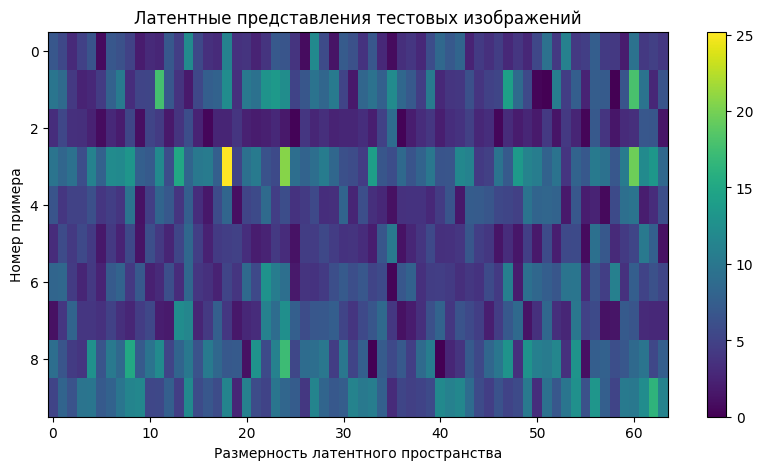

In [ ]:
encoder = Model(input_layer, encoded)
latent_representations = encoder.predict(x_test[:n])

print(f"Пример латентного представления (размерность {LATENT_DIM}):")
print(latent_representations[0])

plt.figure(figsize=(10, 5))
plt.imshow(latent_representations, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Латентные представления тестовых изображений')
plt.xlabel('Размерность латентного пространства')
plt.ylabel('Номер примера')
plt.show()

### Шаг 3. Реализация вариационного автокодировщика (VAE)

Вариационный автокодировщик сделаем в виде класса для удобства

Тут пришлось помучаться с лоссом, но вроде как все в итоге удачно получилось

In [ ]:
latent_dim = 2
input_shape = (28, 28, 1)

class VAE(Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        
    def build_encoder(self):
        inputs = Input(shape=input_shape)
        x = Flatten()(inputs)
        x = Dense(128, activation='relu')(x)
        mu = Dense(self.latent_dim)(x)
        log_var = Dense(self.latent_dim)(x)
        z = Lambda(self.sampling)([mu, log_var])
        return Model(inputs, [mu, log_var, z], name='encoder')
    
    def build_decoder(self):
        inputs = Input(shape=(self.latent_dim,))
        x = Dense(128, activation='relu')(inputs)
        x = Dense(28*28, activation='sigmoid')(x)
        outputs = Reshape(input_shape)(x)
        return Model(inputs, outputs, name='decoder')
    
    def sampling(self, args):
        mu, log_var = args
        epsilon = K.random_normal(shape=(K.shape(mu)[0], self.latent_dim))
        return mu + K.exp(0.5 * log_var) * epsilon
    
    def call(self, inputs):
        mu, log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        loss = self.vae_loss(inputs, reconstructed, mu, log_var)
        self.add_loss(loss)
        return reconstructed
    
    def vae_loss(self, inputs, reconstructions, mu, log_var):
        reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, reconstructions)
        reconstruction_loss = tf.reduce_sum(reconstruction_loss, axis=[1, 2])
        kl_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=1)
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        return total_loss

    def generate(self, n=10):
        z_samples = np.random.normal(size=(n, self.latent_dim))
        generated = self.decoder.predict(z_samples)
        plt.figure(figsize=(10, 2))
        for i in range(n):
            plt.subplot(1, n, i + 1)
            plt.imshow(generated[i].reshape(28, 28), cmap='gray')
            plt.axis('off')
        plt.show()


vae = VAE(latent_dim)
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=50, batch_size=256, validation_data=(x_test, None))

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 307.7716 - val_loss: 190.0526
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 186.8935 - val_loss: 178.2567
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 176.9301 - val_loss: 171.5040
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 170.5479 - val_loss: 168.6294
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 168.0541 - val_loss: 167.2333
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 166.6667 - val_loss: 165.8617
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 165.5089 - val_loss: 164.9194
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 164.5627 - val_loss: 164.1652
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 163.6364 - val_loss: 163.4987
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 162.5878 - val_loss: 162.6618
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 162.4626 - val_loss: 161.99

Теперь визуализируем результаты

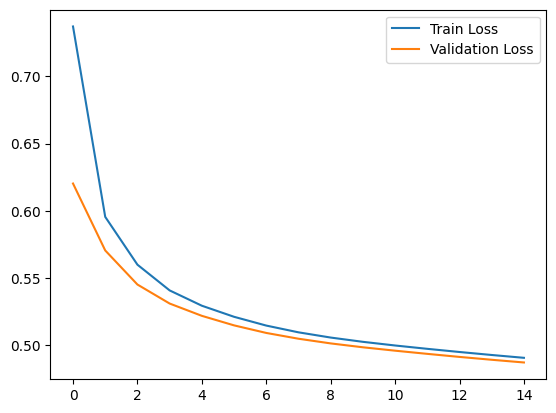

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


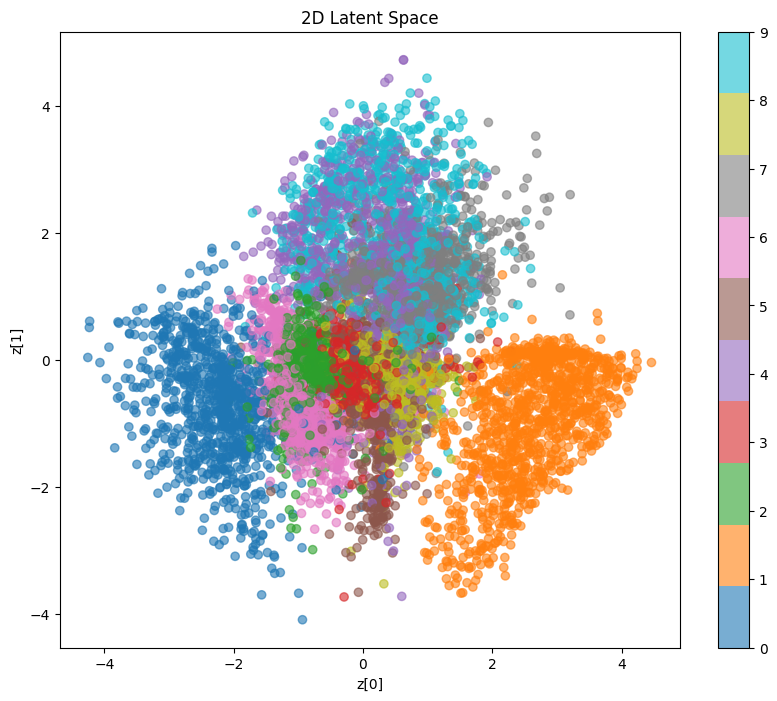

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


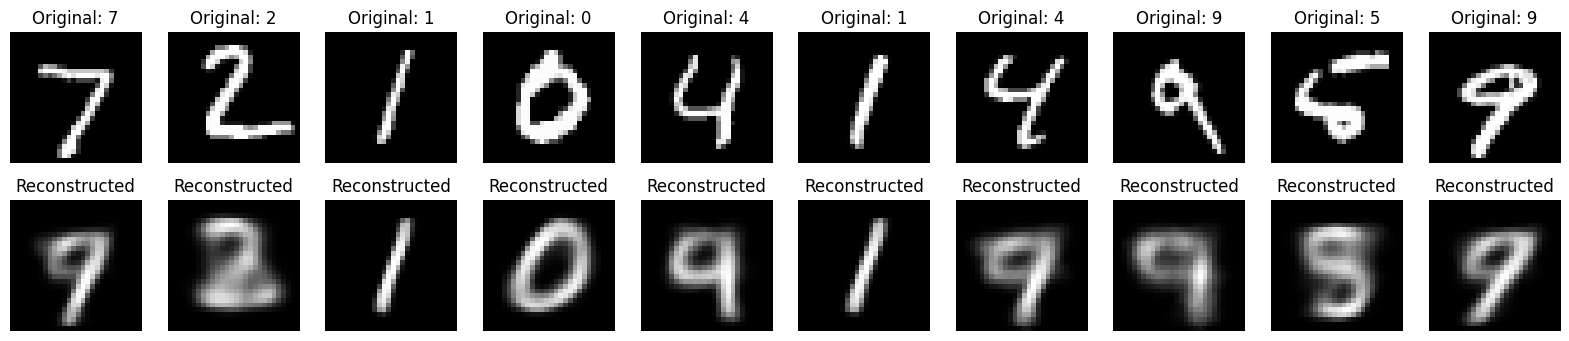

In [152]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


mu, _, _ = vae.encoder.predict(x_test)
plt.figure(figsize=(10, 8))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='tab10', alpha=0.6)
plt.colorbar()
plt.title('2D Latent Space')
plt.xlabel('z[0]')
plt.ylabel('z[1]')
plt.show()

test_images = x_test[:10]
reconstructed = vae.predict(test_images)

plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Original: {y_test[i]}")
    plt.axis('off')

    ax = plt.subplot(2, 10, i + 11)
    plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

### Шаг. 4 Сравнение PCA, AE и VAE

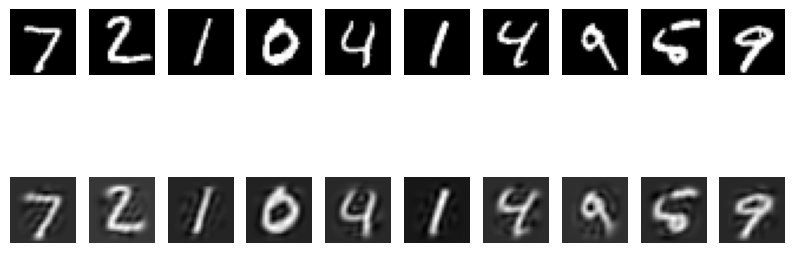

In [ ]:
x_train_flat = x_train.reshape(len(x_train), -1)
x_test_flat = x_test.reshape(len(x_test), -1)

pca = PCA(n_components=64)
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

x_train_reconstructed = pca.inverse_transform(x_train_pca)
x_test_reconstructed = pca.inverse_transform(x_test_pca)

def visualize_reconstruction(original, reconstructed, num_images=10):
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

visualize_reconstruction(x_test_flat, x_test_reconstructed)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


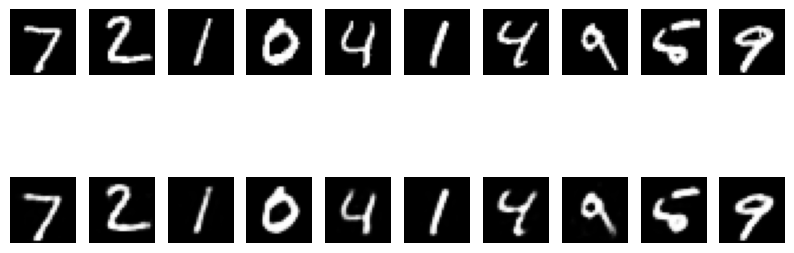

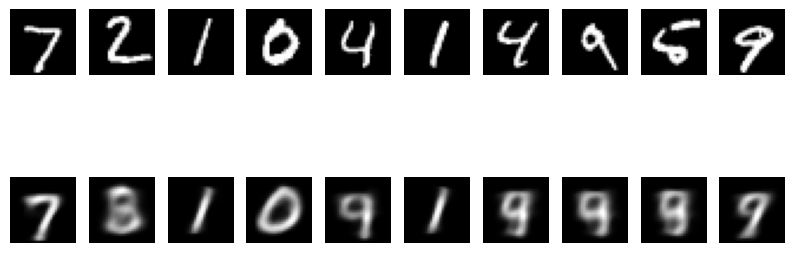

In [ ]:
x_test_ae_reconstructed = autoencoder.predict(x_test)

x_test_vae_reconstructed = vae.predict(x_test)

visualize_reconstruction(x_test.squeeze(), x_test_ae_reconstructed.squeeze())
visualize_reconstruction(x_test.squeeze(), x_test_vae_reconstructed.squeeze())

In [ ]:
mse_pca = mean_squared_error(x_test_flat, x_test_reconstructed)
print(f"MSE для PCA: {mse_pca}")

x_test_ae_flat = x_test_ae_reconstructed.reshape(len(x_test_ae_reconstructed), -1)
x_test_vae_flat = x_test_vae_reconstructed.reshape(len(x_test_vae_reconstructed), -1)

mse_ae = mean_squared_error(x_test_flat, x_test_ae_flat)
mse_vae = mean_squared_error(x_test_flat, x_test_vae_flat)

print(f"MSE для AE: {mse_ae}")
print(f"MSE для VAE: {mse_vae}")

MSE для PCA: 0.009046790190041065
MSE для AE: 0.0041024768725037575
MSE для VAE: 0.04820094630122185


Визуализация латентного пространства

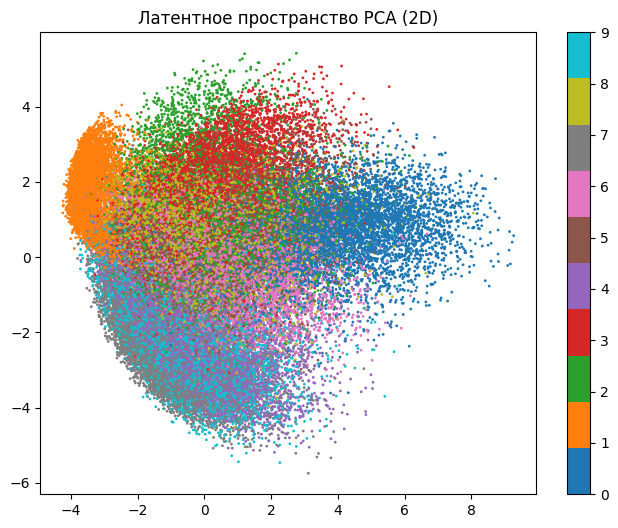

In [ ]:
pca_2d = PCA(n_components=2)
x_train_pca_2d = pca_2d.fit_transform(x_train_flat)

plt.figure(figsize=(8, 6))
plt.scatter(x_train_pca_2d[:, 0], x_train_pca_2d[:, 1], c=y_train, cmap='tab10', s=1)
plt.colorbar()
plt.title("Латентное пространство PCA (2D)")
plt.show()

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


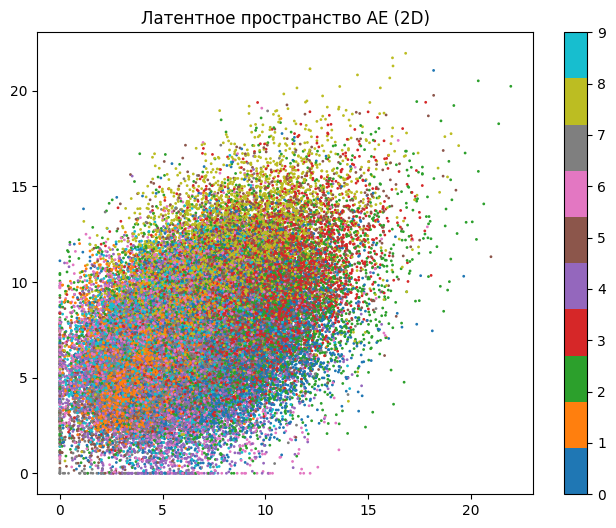

In [ ]:
x_train_ae_latent = encoder.predict(x_train)
plt.figure(figsize=(8, 6))
plt.scatter(x_train_ae_latent[:, 0], x_train_ae_latent[:, 1], c=y_train, cmap='tab10', s=1)
plt.colorbar()
plt.title("Латентное пространство AE (2D)")
plt.show()

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


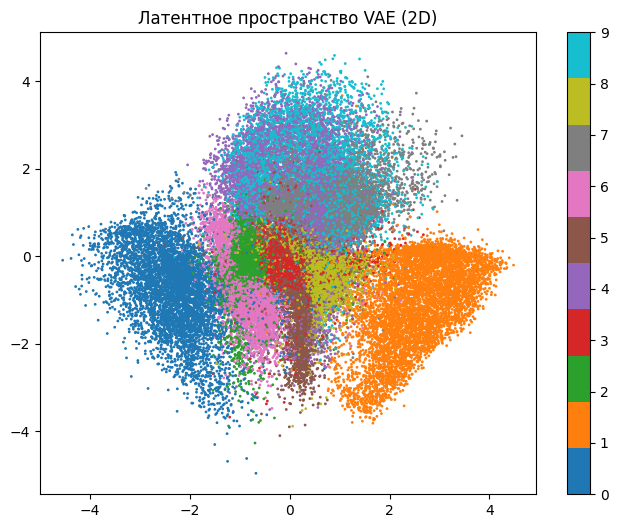

In [153]:
mu, _, _ = vae.encoder.predict(x_train)
plt.figure(figsize=(8, 6))
plt.scatter(mu[:, 0], mu[:, 1], c=y_train, cmap='tab10', s=1)
plt.colorbar()
plt.title("Латентное пространство VAE (2D)")
plt.show()

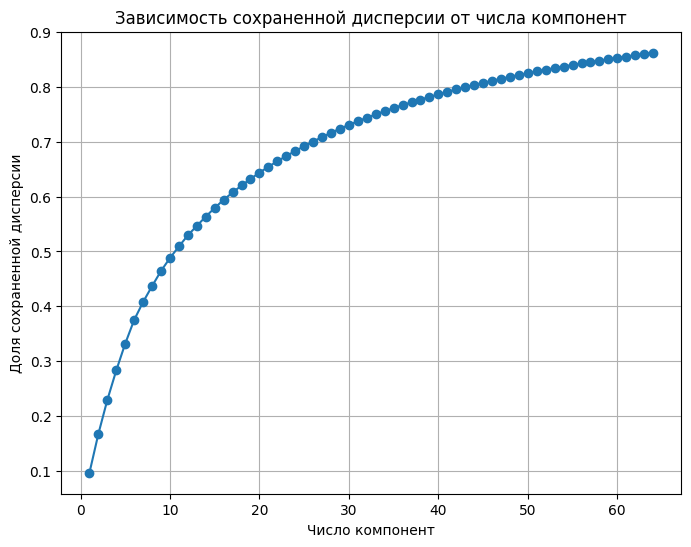

In [ ]:
explained_variance = []
components_range = range(1, 65)

for n in components_range:
    pca = PCA(n_components=n)
    pca.fit(x_train_flat)
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(8, 6))
plt.plot(components_range, explained_variance, marker='o')
plt.title("Зависимость сохраненной дисперсии от числа компонент")
plt.xlabel("Число компонент")
plt.ylabel("Доля сохраненной дисперсии")
plt.grid()
plt.show()

Попробуем совместную реализацю PCA и AE

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_87 (InputLayer)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_210 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 64)             │         2,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,192 (16.38 KB)

 Trainable params: 4,192 (16.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8345 - val_loss: 0.6203
Epoch 2/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6077 - val_loss: 0.5706
Epoch 3/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5673 - val_loss: 0.5453
Epoch 4/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5449 - val_loss: 0.5311
Epoch 5/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5312 - val_loss: 0.5220
Epoch 6/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5241 - val_loss: 0.5149
Epoch 7/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5162 - val_loss: 0.5093
Epoch 8/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5121 - val_loss: 0.5050
Epoch 9/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5066 - val_loss: 0.5015
Epoch 10/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5040 - val_loss: 0.4986
Epoch 11/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5008 - val_loss: 0.4961
Epoch 12/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

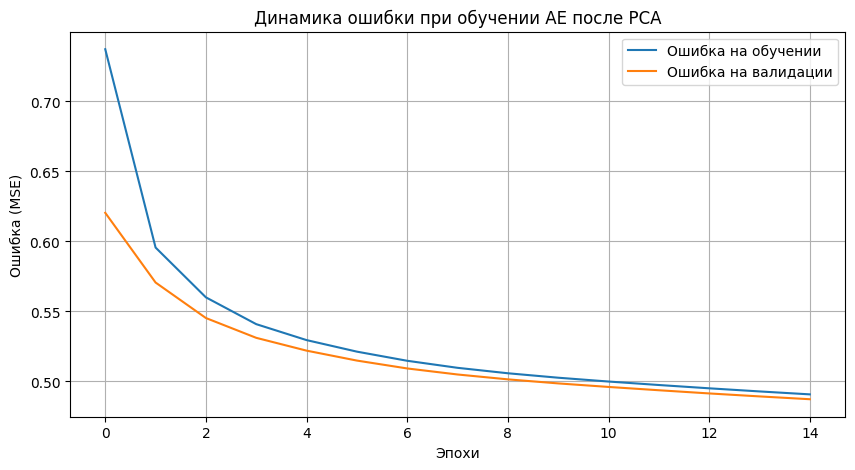

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


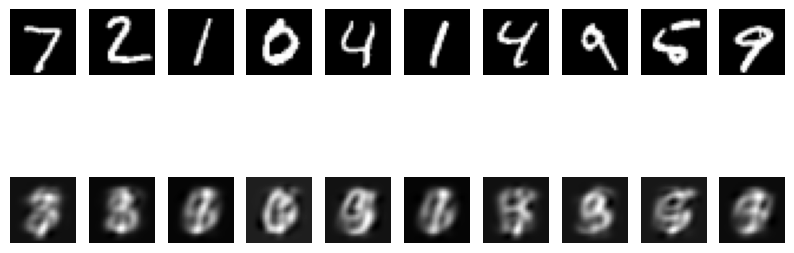

In [ ]:
x_train_flat = x_train.reshape(len(x_train), -1)
x_test_flat = x_test.reshape(len(x_test), -1)

pca = PCA(n_components=64)
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)


PCA_DIM = 64
LATENT_DIM = 32

input_layer = Input(shape=(PCA_DIM,))
encoded = Dense(LATENT_DIM, activation='relu')(input_layer)
decoded = Dense(PCA_DIM, activation='sigmoid')(encoded)

autoencoder_pca = Model(input_layer, decoded)
autoencoder_pca.compile(optimizer='adam', loss='mse')
autoencoder_pca.summary()

history = autoencoder_pca.fit(
    x_train_pca, x_train_pca,
    epochs=15,
    batch_size=256,
    validation_split=0.1,
    shuffle=True
)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Ошибка на обучении')
plt.plot(history.history['val_loss'], label='Ошибка на валидации')
plt.title('Динамика ошибки при обучении AE после PCA')
plt.xlabel('Эпохи')
plt.ylabel('Ошибка (MSE)')
plt.legend()
plt.grid(True)
plt.show()

x_test_pca_reconstructed = autoencoder_pca.predict(x_test_pca)
x_test_reconstructed_original = pca.inverse_transform(x_test_pca_reconstructed)

def visualize_reconstruction(original, reconstructed, num_images=10):
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

visualize_reconstruction(x_test_flat, x_test_reconstructed_original)


Выводы:
- PCA — линейный метод, он не умеет моделировать нелинейные зависимости, а AE/VAE — нейросети, которые могут захватывать сложные закономерности.
- Если данные примерно линейно разделимы или когда важна интерпретируемость и быстрота, PCA проще и быстрее.
- Максимизация дисперсии не гарантирует, что важные детали изображения будут сохранены — иногда важна структура, а не просто разброс данных.
- Полезно комбинировать PCA и AE, когда нужно сократить размерность для более быстрой или стабильной тренировки AE, или когда данные очень большие и обучение AE на полных данных тяжело.

### Шаг 5. Генерация данных

Для генерации будем использовать уже обученную VAE

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


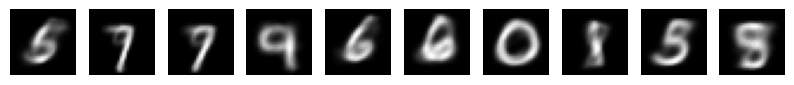

In [ ]:
vae.generate(10)

Генерация довольно неплохая, цифры относительно различимы

Далее - интерполяция

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


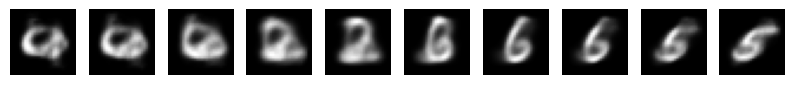

In [ ]:
point_a = np.random.normal(size=(latent_dim,))
point_b = np.random.normal(size=(latent_dim,))

interpolation_steps = 10
interpolated_points = np.linspace(point_a, point_b, interpolation_steps)

interpolated_images = vae.decoder.predict(interpolated_points)

plt.figure(figsize=(10, 2))
for i in range(interpolation_steps):
    plt.subplot(1, interpolation_steps, i + 1)
    plt.imshow(interpolated_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

Построим сетку в латентном пространстве

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


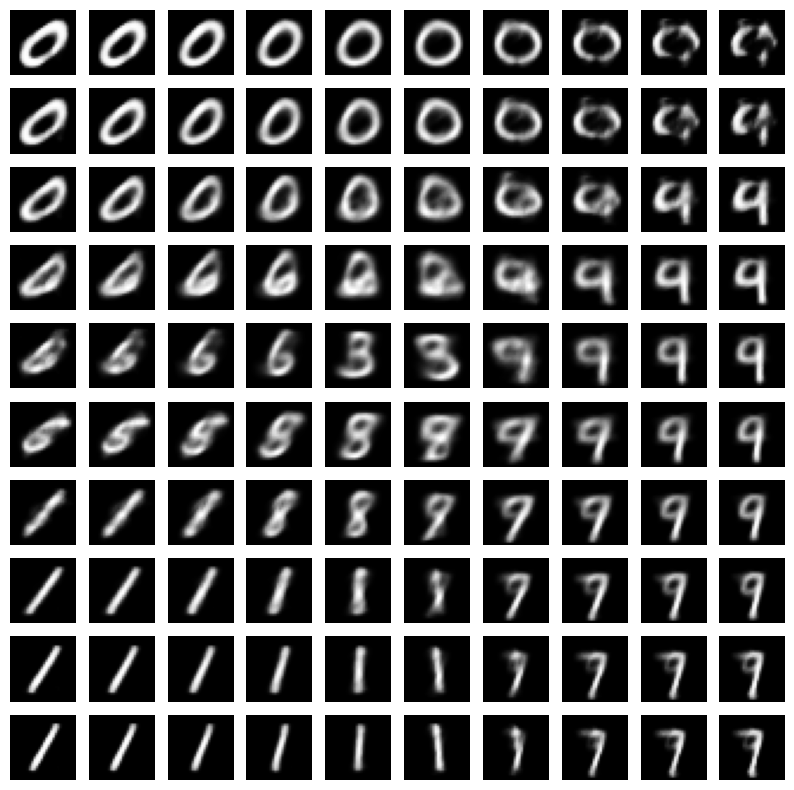

In [ ]:
if latent_dim == 2:
    grid_x = np.linspace(-3, 3, 10)
    grid_y = np.linspace(-3, 3, 10)
    latent_grid = np.array([[x, y] for x in grid_x for y in grid_y])
    grid_images = vae.decoder.predict(latent_grid)
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(grid_images):
        plt.subplot(10, 10, i + 1)
        plt.imshow(img.reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


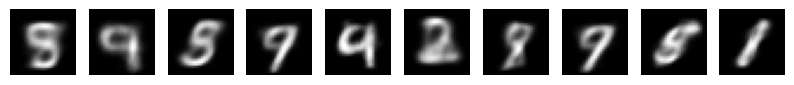

In [161]:
latent_samples = np.random.normal(size=(10, latent_dim))
noise_level = 0.5
noisy_points = latent_samples + np.random.normal(scale=noise_level, size=latent_samples.shape)
noisy_images = vae.decoder.predict(noisy_points)
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

Латентное пространство: 2


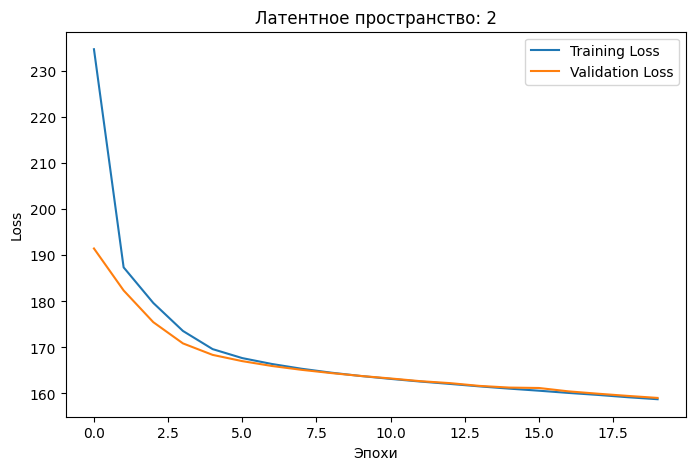

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


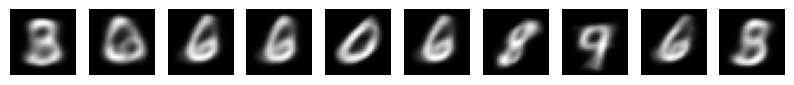

Латентное пространство: 8


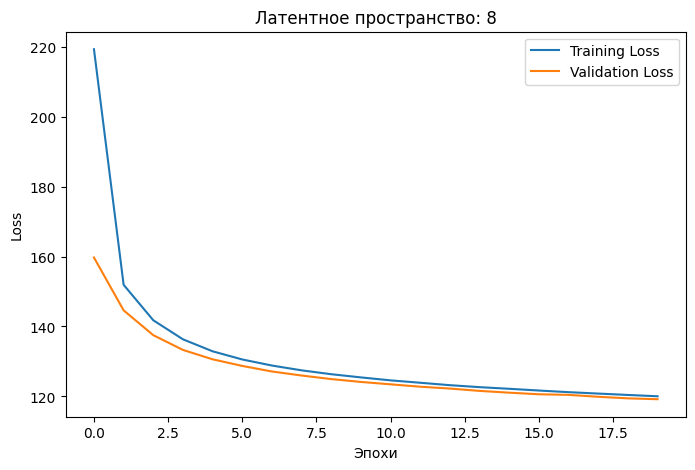

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


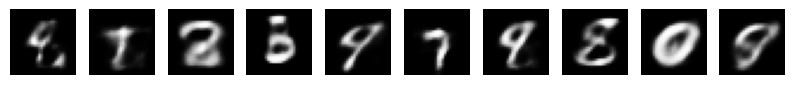

Латентное пространство: 16


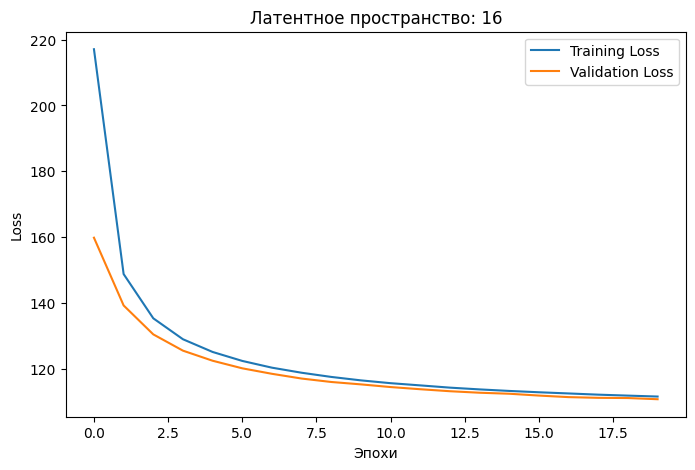

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


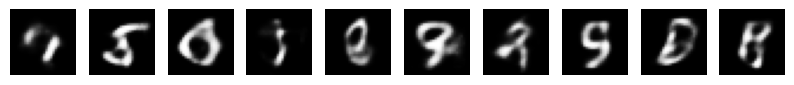

In [ ]:
latent_dim_options = [2, 8, 16]
for dim in latent_dim_options:
    print(f"Латентное пространство: {dim}")
    
    vae_new = VAE(dim)
    vae_new.compile(optimizer='adam')

    history = vae_new.fit(
        x_train, 
        epochs=20, 
        batch_size=256, 
        validation_data=(x_test, None), 
        verbose=0
    )

    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Латентное пространство: {dim}')
    plt.xlabel('Эпохи')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    latent_samples = np.random.normal(size=(10, dim))
    generated_images = vae_new.decoder.predict(latent_samples)
    
    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

Таким образом, лоссы меньше всего на латентном пространстве 16, хотя цифры на изображениях лучше угадываются на 2 и 8

### Шаг 6

Попробуем обучить GAN и сравнить результаты генерации с VAE

Первая самая простая версия не показала хоть сколько-то значимых результатов, по
тому была взята модель посильнее + добавлена интерполяция

Training DCGAN:   0%|          | 0/3000 [00:06<?, ?it/s]

0 [D loss: 0.7106, acc: 23.44%] [G loss: 0.7136]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


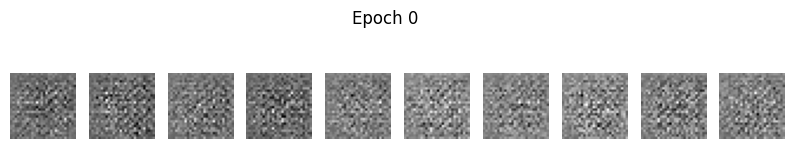

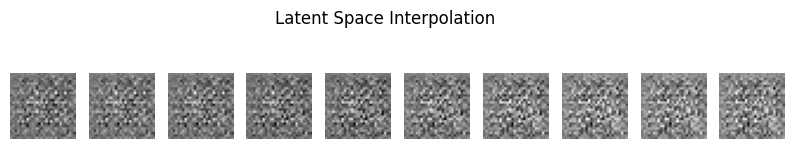

Training DCGAN:  17%|█▋        | 500/3000 [11:49<55:21,  1.33s/it]  

500 [D loss: 0.7843, acc: 4.53%] [G loss: 0.4543]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


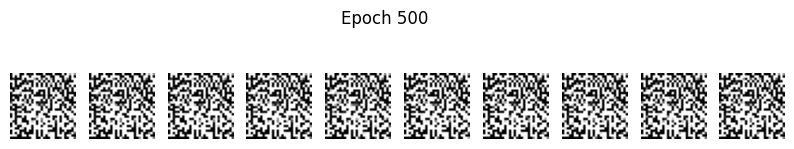

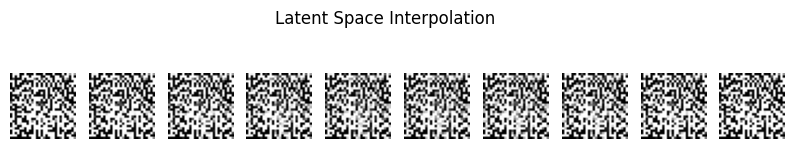

Training DCGAN:  33%|███▎      | 1000/3000 [23:19<44:35,  1.34s/it] 

1000 [D loss: 0.8264, acc: 4.46%] [G loss: 0.4428]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


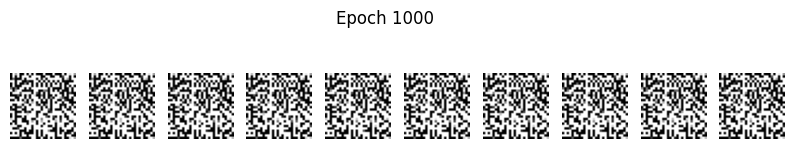

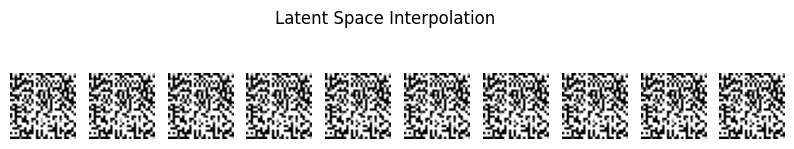

Training DCGAN:  50%|█████     | 1500/3000 [34:37<33:55,  1.36s/it]  

1500 [D loss: 0.8415, acc: 4.43%] [G loss: 0.4381]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


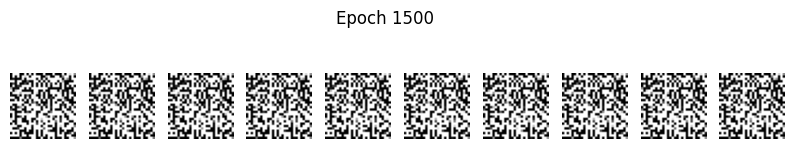

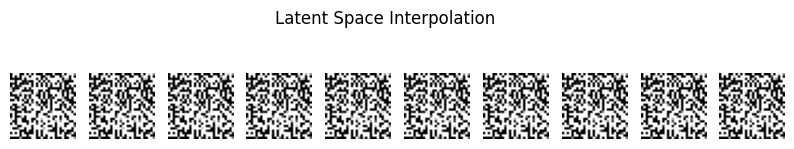

Training DCGAN:  67%|██████▋   | 2000/3000 [45:52<23:56,  1.44s/it]

2000 [D loss: 0.8496, acc: 4.43%] [G loss: 0.4351]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


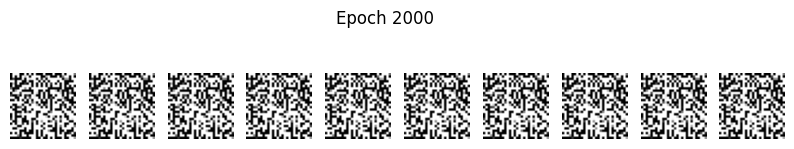

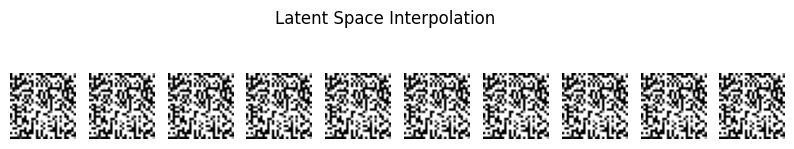

Training DCGAN:  83%|████████▎ | 2500/3000 [57:13<11:22,  1.36s/it]

2500 [D loss: 0.8547, acc: 4.43%] [G loss: 0.4329]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


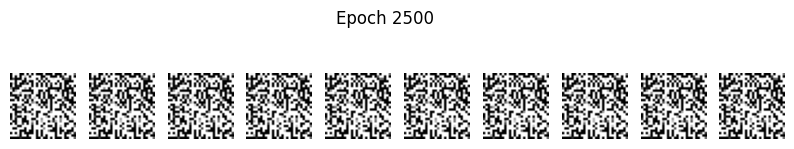

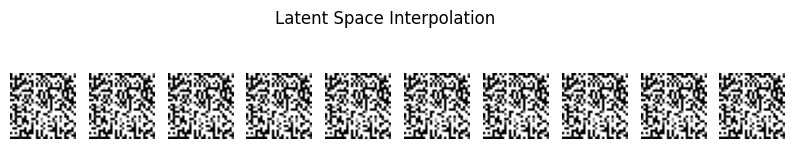

Training DCGAN: 100%|██████████| 3000/3000 [1:08:24<00:00,  1.37s/it]


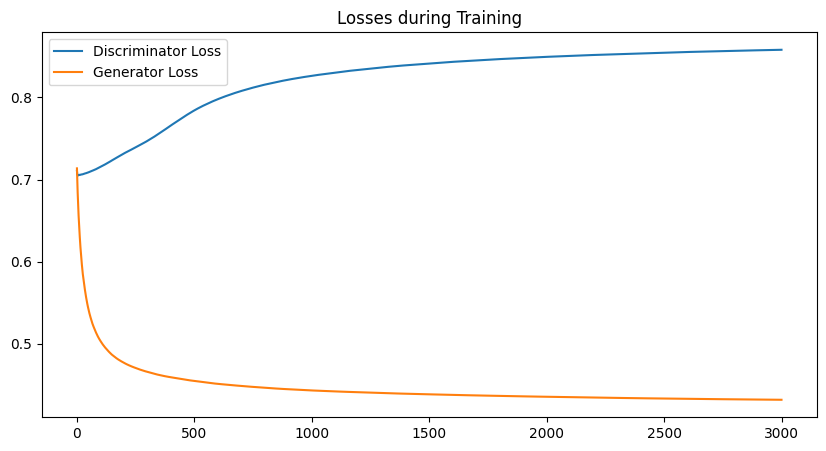

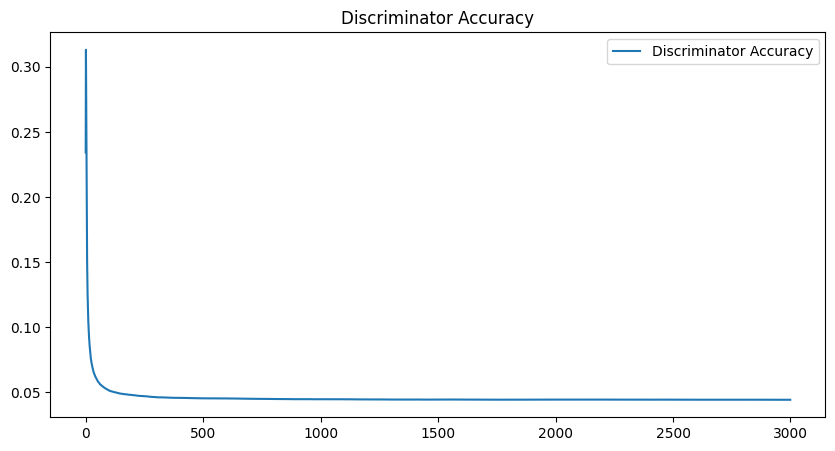

In [ ]:
latent_dim = 100
img_shape = (28, 28, 1)
epochs = 3000
batch_size = 64
sample_interval = 500
d_lr = 0.0004
g_lr = 0.0001

(x_train, _), (_, _) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)

def build_generator():
    model = Sequential([
        Dense(7 * 7 * 512, use_bias=False, input_dim=latent_dim),
        BatchNormalization(),
        LeakyReLU(0.2),
        Reshape((7, 7, 512)),
        
        Conv2DTranspose(256, 5, 1, 'same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(0.2),
        
        Conv2DTranspose(128, 5, 2, 'same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(0.2),
        
        Conv2DTranspose(64, 5, 2, 'same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(0.2),
        
        Conv2DTranspose(1, 5, 1, 'same', activation='tanh', use_bias=False)
    ])
    return model

def build_discriminator():
    model = Sequential([
        Conv2D(64, 5, 2, 'same', input_shape=img_shape),
        LeakyReLU(0.2),
        Dropout(0.3),
        
        Conv2D(128, 5, 2, 'same'),
        LeakyReLU(0.2),
        Dropout(0.3),
        
        Conv2D(256, 5, 2, 'same'),
        LeakyReLU(0.2),
        Dropout(0.3),
        
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(d_lr, 0.5), metrics=['accuracy'])
    return model


generator = build_generator()
discriminator = build_discriminator()
discriminator.trainable = False

gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(g_lr, 0.5))


d_losses, g_losses, d_accs = [], [], []


def interpolate_latent_space(n=10):
    z1, z2 = np.random.normal(0, 1, (1, latent_dim)), np.random.normal(0, 1, (1, latent_dim))
    vectors = np.array([z1 * (1 - alpha) + z2 * alpha for alpha in np.linspace(0, 1, n)]).reshape(n, latent_dim)
    gen_imgs = generator.predict(vectors, verbose=0)
    gen_imgs = 0.5 * gen_imgs + 0.5
    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(gen_imgs[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle("Latent Space Interpolation")
    plt.show()



def sample_images(epoch, n=10):
    noise = np.random.normal(0, 1, (n, latent_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5
    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(gen_imgs[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch}")
    plt.show()


def train_dcgan(epochs, batch_size, sample_interval):
    for epoch in tqdm(range(epochs), desc="Training DCGAN"):
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise, verbose=0)
        
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_imgs = x_train[idx]
        
        real_y = np.ones((batch_size, 1)) * 0.9
        fake_y = np.zeros((batch_size, 1))

        flip_idx = np.random.choice(batch_size, int(0.05 * batch_size))
        real_y[flip_idx] = 0
        fake_y[flip_idx] = 1
        
        d_loss_real = discriminator.train_on_batch(real_imgs, real_y)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake_y)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
        
        d_losses.append(d_loss[0])
        d_accs.append(d_loss[1])
        g_losses.append(g_loss)
        
        if epoch % sample_interval == 0 or epoch == epochs:
            tqdm.write(f"{epoch} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")
            sample_images(epoch)
            interpolate_latent_space()

    plt.figure(figsize=(10,5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.legend()
    plt.title("Losses during Training")
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.plot(d_accs, label='Discriminator Accuracy')
    plt.legend()
    plt.title("Discriminator Accuracy")
    plt.show()

train_dcgan(epochs, batch_size, sample_interval)

На генерации что-то видимо пошло не так и генерация, как и интерполяция, не дала значимых результатов, однако попробовать ее реализовать в рамках данной лабораторной работы было довольно интересно